<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            10000 non-null  object 
 1   age                    10000 non-null  int64  
 2   gender                 10000 non-null  object 
 3   senior_citizen         10000 non-null  int64  
 4   partner                10000 non-null  object 
 5   dependents             10000 non-null  object 
 6   tenure                 10000 non-null  int64  
 7   phone_service          10000 non-null  object 
 8   multiple_lines         10000 non-null  object 
 9   internet_service       10000 non-null  object 
 10  online_security        10000 non-null  object 
 11  online_backup          10000 non-null  object 
 12  device_protection      10000 non-null  object 
 13  tech_support           10000 non-null  object 
 14  streaming_tv           10000 non-null  object 
 15  str

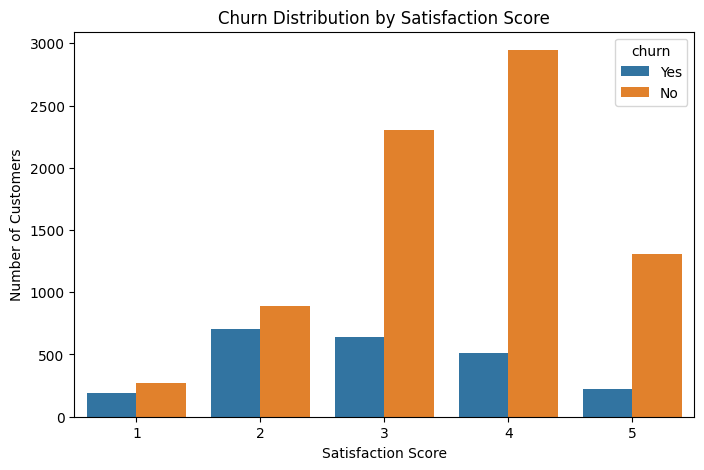

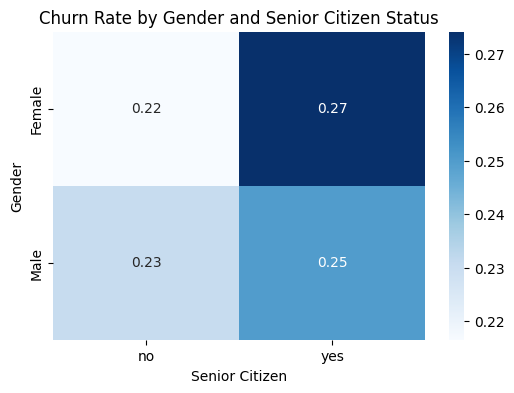

Decision Tree
Accuracy: 0.784

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87      1546
           1       0.57      0.19      0.29       454

    accuracy                           0.78      2000
   macro avg       0.69      0.58      0.58      2000
weighted avg       0.75      0.78      0.74      2000


Confusion Matrix:
 [[1480   66]
 [ 366   88]]
Logistic Regression
Accuracy: 0.792

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.95      0.88      1546
           1       0.60      0.25      0.35       454

    accuracy                           0.79      2000
   macro avg       0.71      0.60      0.61      2000
weighted avg       0.76      0.79      0.76      2000


Confusion Matrix:
 [[1472   74]
 [ 342  112]]
Random Forest : 
Accuracy: 0.7785

Classification Report:
               precision    recall  f1-score   support

           0       0.7

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#Models
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
churn = pd.read_csv('/home/nalin/Desktop/LABSML/ML_LAB1_Assignment/customer_churn_data.csv')


#PreProcessing:

churn.describe()

churn.info()

churn.head()

#making the SeniorCitizen attribute take up only yes's and no's:
churn["senior_citizen"] = churn["senior_citizen"].replace({1:"yes",0:"no"})

#Churn Rate :
churn_rate = (churn["churn"] == "Yes").mean()
print(f"Overall churn rate: {churn_rate:.2%}")

#Function to calculate the Churn Rate by Category:
def churn_rate_by_category(df, target="churn"):
    results = {}
    # loop through all categorical columns except the target
    for col in df.select_dtypes(include=["object", "category"]).columns:
        if col == target:
            continue
        churn_rate = df.groupby(col)[target].apply(lambda x: (x == "Yes").mean())
        results[col] = churn_rate
    return results

rates = churn_rate_by_category(churn)

# Display results
for col, series in rates.items():
    print(f"\nChurn rate by {col}:")
    print(series)


#plotting the churn against satisfaction scores:

plt.figure(figsize=(8,5))
sns.countplot(data=churn, x="customer_satisfaction", hue="churn")
plt.title("Churn Distribution by Satisfaction Score")
plt.xlabel("Satisfaction Score")
plt.ylabel("Number of Customers")
plt.show()


#plotting a correlation between churn and gender:
# Crosstab: churn proportion for each Gender × SeniorCitizen group
heat_data = pd.crosstab(
    [churn["gender"], churn["senior_citizen"]], 
    churn["churn"], 
    normalize="index"
)

# Only keep churn="Yes" proportions
heat_data = heat_data["Yes"].unstack()  

plt.figure(figsize=(6,4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.title("Churn Rate by Gender and Senior Citizen Status")
plt.ylabel("Gender")
plt.xlabel("Senior Citizen")
plt.show()

#implementing the Model::

#feature Scaling:


scaler = MinMaxScaler()
churn[["customer_satisfaction", "monthly_charges", "total_charges"]] = scaler.fit_transform(
    churn[["customer_satisfaction", "monthly_charges", "total_charges"]]
)

#splitting the Data:

X = churn.drop("churn", axis=1)   
y = churn["churn"]           



le = LabelEncoder()
y = le.fit_transform(y)  # Yes=1, No=0



X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% test, 80% train
    random_state=42,  # reproducibility
    stratify=y        # keep churn ratio same in train & test
)

#Decision Tree Preprocssing, Encoding Categorical Variables:

num_features = ["customer_satisfaction", "monthly_charges", "total_charges"]
cat_features = [col for col in X.columns if col not in num_features]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ("num", "passthrough", num_features)
])


clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42, max_depth=5))
])

clf.fit(X_train, y_train)



#Evaluation:


y_pred = clf.predict(X_test)

print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#logistic Regression:

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver="liblinear"))
])

clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # churn probabilities

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#Random Forest:


num_features = ["customer_satisfaction", "monthly_charges", "total_charges"]
cat_features = [col for col in X.columns if col not in num_features]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
], remainder="passthrough")  # keep numerical features as-is
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,   # number of trees
        max_depth=None,     # let trees grow fully
        random_state=42,
        class_weight="balanced"  # helps if churn classes are imbalanced
    ))
])
print("Random Forest : ")
clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

#SVM:

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel="rbf", C=1, gamma="scale", class_weight="balanced", random_state=42))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("SVM :")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
churn = pd.read_csv('/home/nalin/Desktop/LABSML/ML_LAB1_Assignment/customer_churn_data.csv')


#PreProcessing:
churn["senior_citizen"] = churn["senior_citizen"].replace({1:"yes",0:"no"})
churn.describe()

churn.info()

churn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            10000 non-null  object 
 1   age                    10000 non-null  int64  
 2   gender                 10000 non-null  object 
 3   senior_citizen         10000 non-null  object 
 4   partner                10000 non-null  object 
 5   dependents             10000 non-null  object 
 6   tenure                 10000 non-null  int64  
 7   phone_service          10000 non-null  object 
 8   multiple_lines         10000 non-null  object 
 9   internet_service       10000 non-null  object 
 10  online_security        10000 non-null  object 
 11  online_backup          10000 non-null  object 
 12  device_protection      10000 non-null  object 
 13  tech_support           10000 non-null  object 
 14  streaming_tv           10000 non-null  object 
 15  str

,customer_id,age,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,customer_satisfaction,support_calls,churn
0,CUST_000001,52,Male,no,Yes,Yes,7,Yes,No,Fiber optic,...,Yes,No,One year,Yes,Electronic check,39.18,294.66,4,3,No
1,CUST_000002,42,Male,no,Yes,No,32,Yes,No,No,...,No internet service,No internet service,One year,Yes,Electronic check,40.36,1286.75,3,1,No
2,CUST_000003,54,Male,no,No,Yes,12,Yes,Yes,Fiber optic,...,Yes,Yes,Month-to-month,No,Bank transfer (automatic),84.77,947.09,2,3,Yes
3,CUST_000004,67,Male,yes,No,No,3,Yes,No,DSL,...,No,No,One year,No,Credit card (automatic),54.14,172.76,4,5,No
4,CUST_000005,41,Female,no,Yes,No,7,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,71.77,466.98,3,3,No
